## 1. Drug-IQ Problem

In [64]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
def load_kruschke():
    le = preprocessing.LabelEncoder()
    k_df = pd.read_csv('iq.csv', index_col=0)
    le.fit(k_df['treatment'])
    k_df['treatment_enc'] = le.transform(k_df['treatment'])
    return k_df
df = load_kruschke()

In [29]:
clr = {'drug' : 'red', 'placebo' : 'blue'}

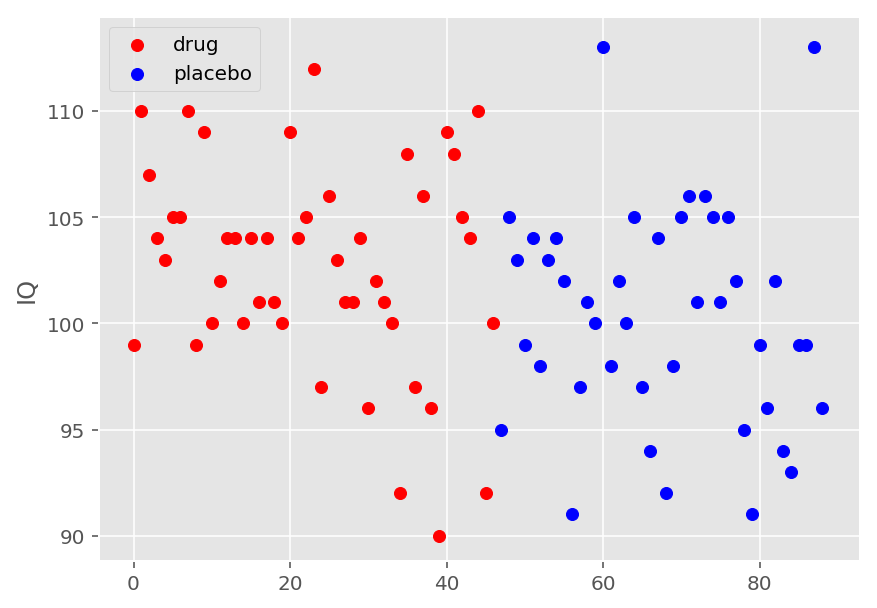

In [160]:
offset = 0
fig = plt.figure(figsize=(15, 5))
for marker in ['drug', 'placebo']:
    df_marker = df.loc[df['treatment'] == marker]
    plt.subplot(1, 2, 1)
    plt.scatter(range(offset, offset + len(df_marker)), df_marker['iq'], color=clr[marker], label=marker)
    offset = len(df_marker)
    plt.legend()
    plt.ylabel('IQ')

In [49]:
df.sample(5)

,treatment,iq,treatment_enc
53,placebo,103.0,1
8,drug,99.0,0
23,drug,112.0,0
79,placebo,91.0,1
18,drug,101.0,0


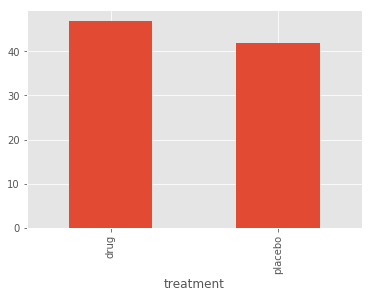

In [50]:
df.groupby('treatment').size().plot(kind='bar')

In [52]:
with pm.Model() as kruschke_model:
    
    # Prior for drug-treated IQ mean.
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    # Prior for placebo-treated IQ mean.
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    
    # Prior for drug treated IQ standard deviation.
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    # Prior for placebo treated IQ standard deviation.
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    
    # Prior for nuisance parameter. Adding a small positive number 
    # guarantees that we never get nu == 0 by accident 
    # (e.g. through rounding error).
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    # Likelihood function for the drug-treated participants' IQ.
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=df[drug_filter]['iq'])
    
    # Likelihood function for the placebo-treated participants' IQ.
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=df[placebo_filter]['iq'])
    
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(
                                     (np.power(sigma_drug, 2) + np.power(sigma_placebo, 2)) / 2
                                  )
                                 )
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

In [179]:
with kruschke_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma_placebo, sigma_drug, mu_placebo, mu_drug]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 473.06draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d1af9b0>,
      dtype=object)

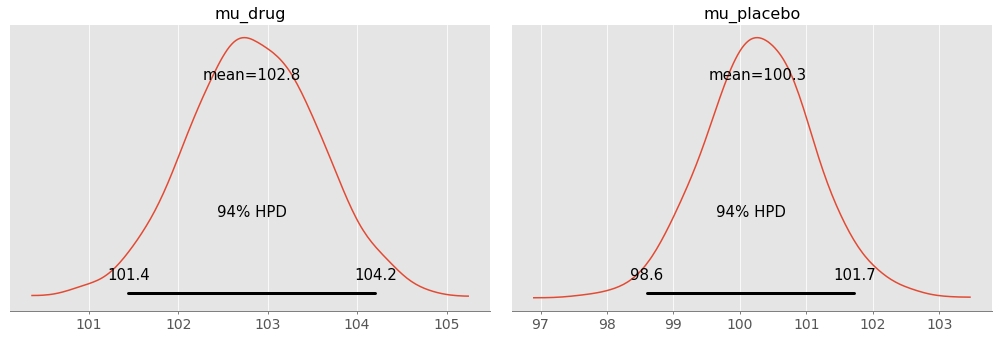

In [57]:
import arviz as az
az.plot_posterior(trace, var_names=['mu_drug', 'mu_placebo'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12cf47cc0>,
      dtype=object)

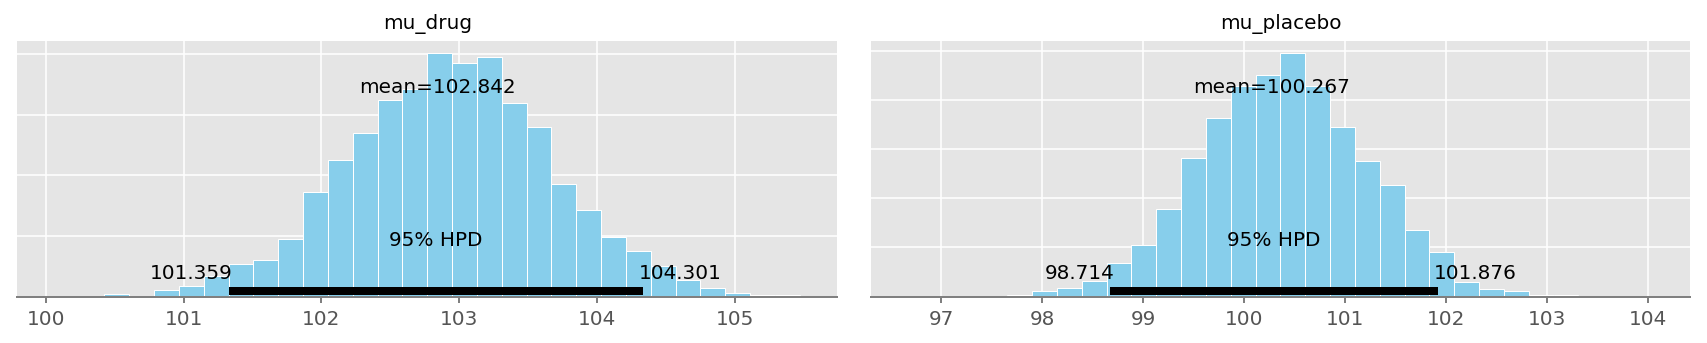

In [181]:
pm.plot_posterior(trace, varnames=['mu_drug', 'mu_placebo'])

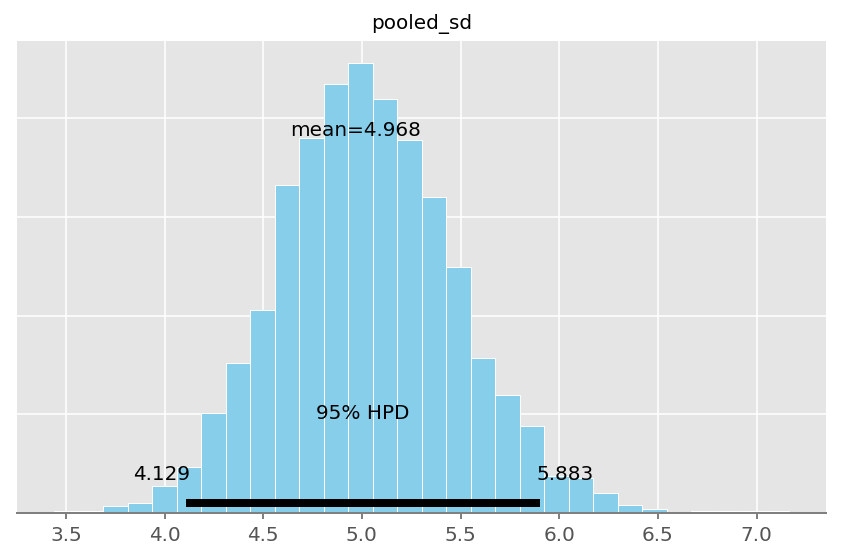

In [183]:
pm.plot_posterior(trace, varnames=['pooled_sd'])

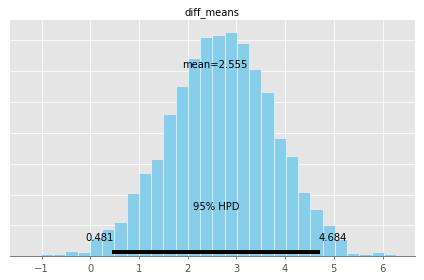

In [61]:
pm.plot_posterior(trace, varnames=['diff_means'])

The difference of means lies between $[0.5, 4.7]$

- **IQR** ?

Text(0.5, 15.5, 'IQ')

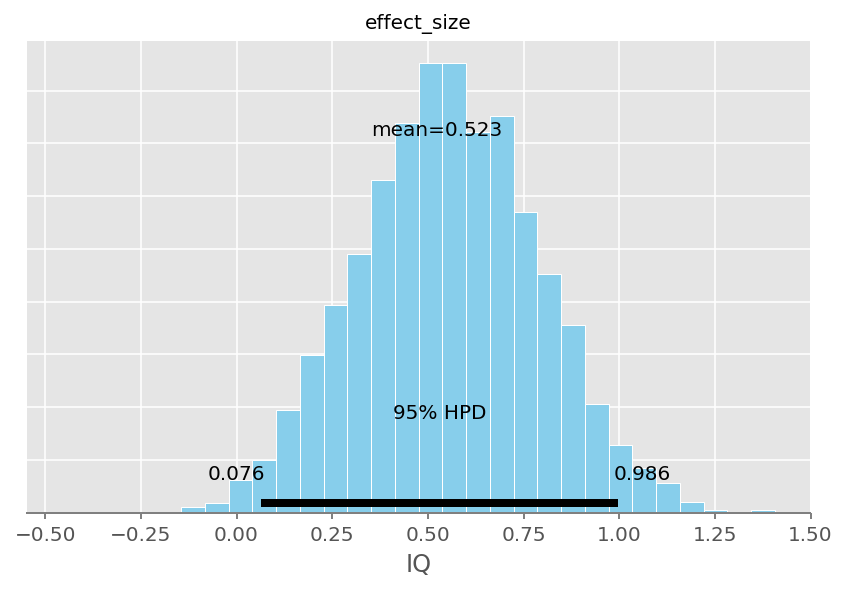

In [182]:
pm.plot_posterior(trace, varnames=['effect_size'])
plt.xlabel('IQ')

### Summary

???

## 2. Chemical Activity Problem

> *The IC50 is the concentration of an inhibitor where the response (or binding) is reduced by half.*

> IC50 of drug $X$ is \_ \_ \_ \_ (95% HPD : [?, ?])
--

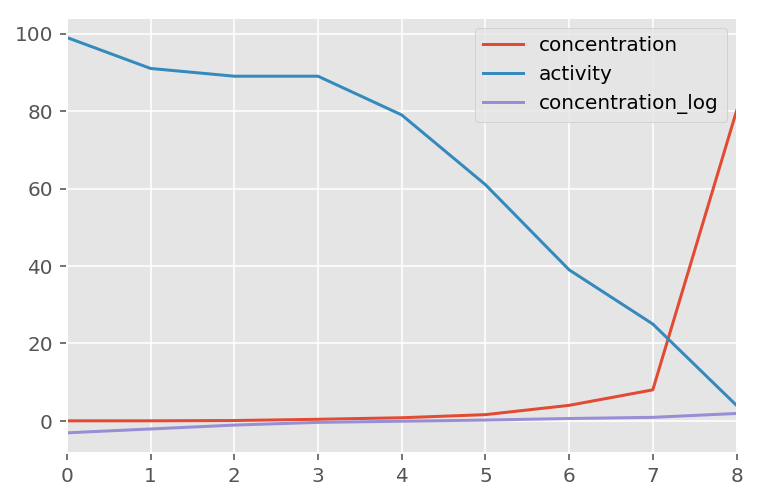

In [67]:
from data import load_ic50

chem_df = load_ic50()
chem_df.plot()

Text(0.5, 0, '$log(concentration)$')

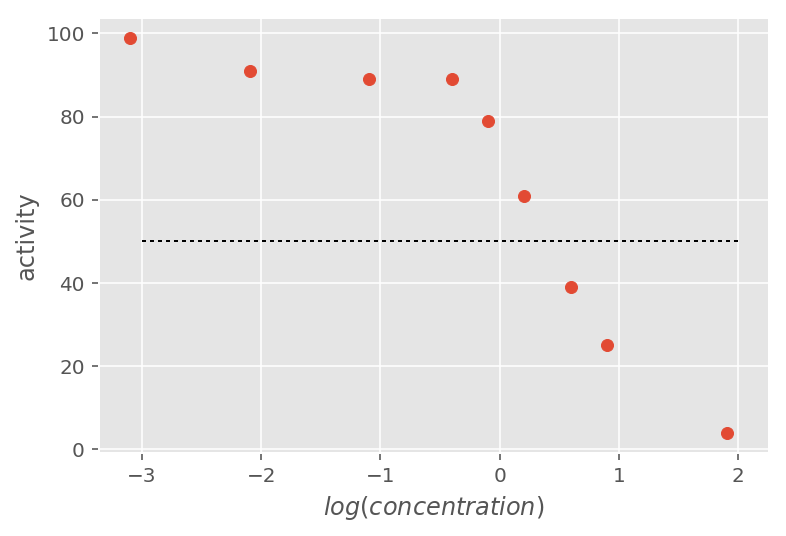

In [175]:
plt.scatter(chem_df['concentration_log'], chem_df['activity'])
plt.plot([-3, 2], [50, 50], 'k-', lw=1,dashes=[2, 2])
plt.ylabel('activity')
plt.xlabel('$log(concentration)$')

# Link Function


$$\frac{\beta}{1 + e^{x - IC50}}$$
--

- $\beta$ is a positive constant

In [73]:
with pm.Model() as ic50_model:
    beta = pm.HalfNormal('beta', sd=100**2)  # half-normal beta constant
    ic50_log10 = pm.Flat('IC50_log10')  # flat prior
    measurement = beta / ( 1 + np.exp(chem_df['concentration_log'].values - ic50_log10))
    y_likelihood = pm.Normal('y_likelihood', mu=measurement,
                          observed=chem_df['activity'])
    ic50 = pm.Deterministic('IC50', np.power(10, ic50_log10))

In [74]:
with ic50_model:
    step = pm.Metropolis()
    ic50_trace = pm.sample(100000, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [IC50_log10]
>Metropolis: [beta]
100%|██████████| 100500/100500 [00:32<00:00, 3107.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b861f60>,
      dtype=object)

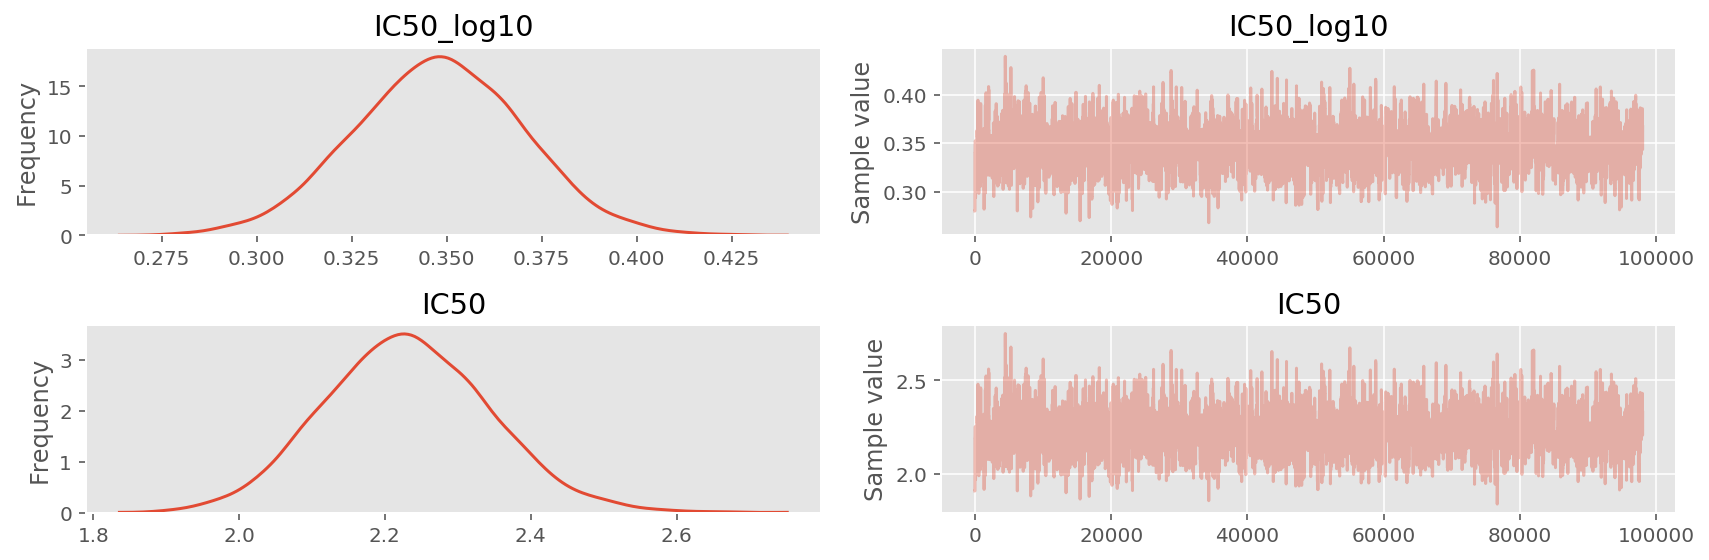

In [75]:
pm.traceplot(ic50_trace[2000:], varnames=['IC50_log10', 'IC50'])  # live: sample from step 2000 onwards.

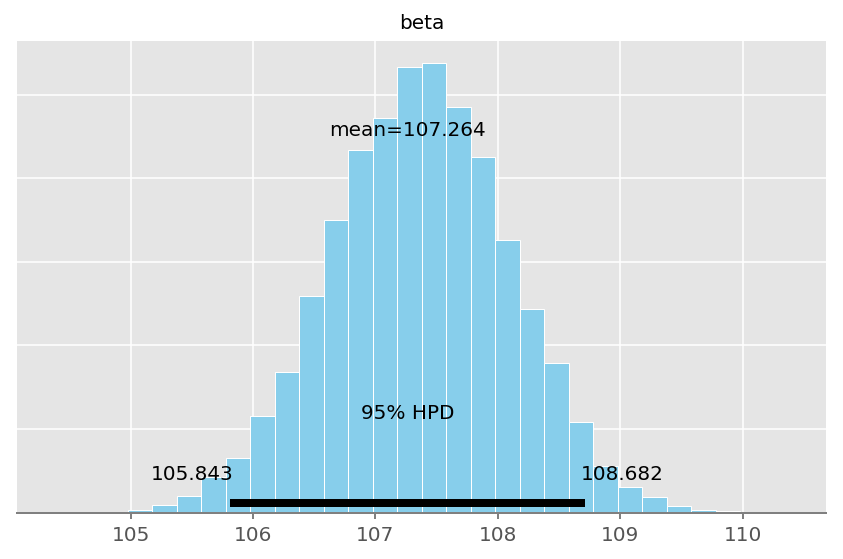

In [177]:
pm.plot_posterior(ic50_trace[2000:], varnames=['beta'])

Text(0.5, 15.5, 'concentration ($mM$)')

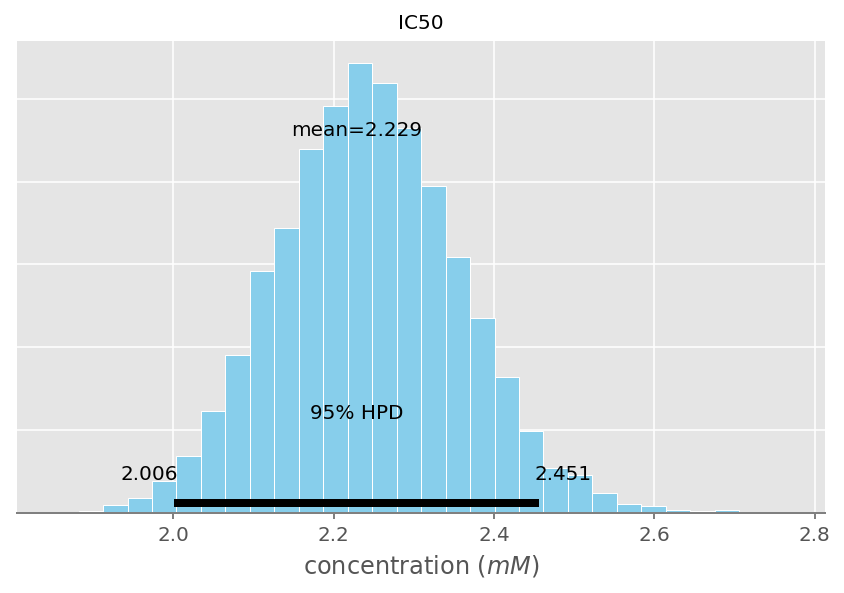

In [176]:
pm.plot_posterior(ic50_trace[2000:], varnames=['IC50'])
plt.xlabel('concentration ($mM$)')

> IC50 of drug $X$ is $2.229\ mM$ (95% HPD : [$2.0$, $2.45$])
---

- $mM$ : milli-molars

## 3. Decay Rate of an unknown radioactive material

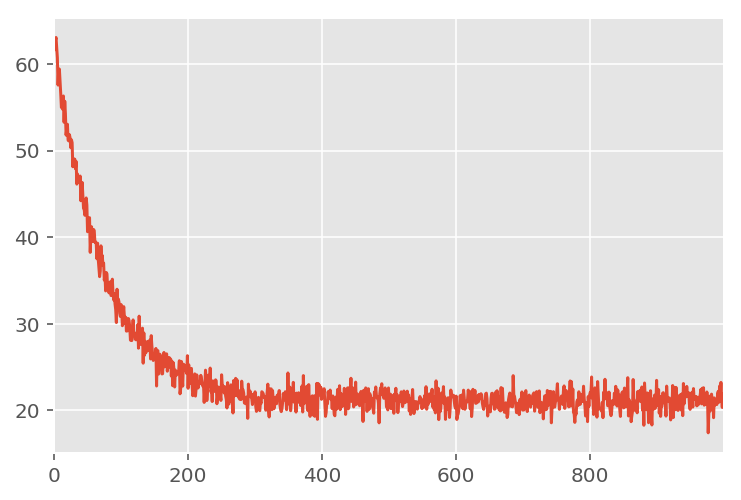

In [78]:
from data import load_decay

decay_df = load_decay()
decay_df['activity'].plot()

$$A e^{-x/\tau} + C$$
--

- parametric form to fit through the data

In [80]:
with pm.Model() as decay_model:
    A = pm.HalfNormal('A', sd=100)
    tau = pm.Exponential('tau', lam=1)
    C = pm.Normal('C', sd=100)
    sd = pm.HalfCauchy('sd', beta=1)
    
    # describes the mathematical relationship between our priors and data
    link = A * np.exp(-decay_df['t'].values / tau) + C  # LINK function
    
    like = pm.Normal('activity', mu=link, sd=sd, observed=decay_df['activity'].values)
    samples = pm.sample(2000, tune=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, C, tau, A]
100%|██████████| 4000/4000 [00:10<00:00, 383.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12184cac8>,
      dtype=object)

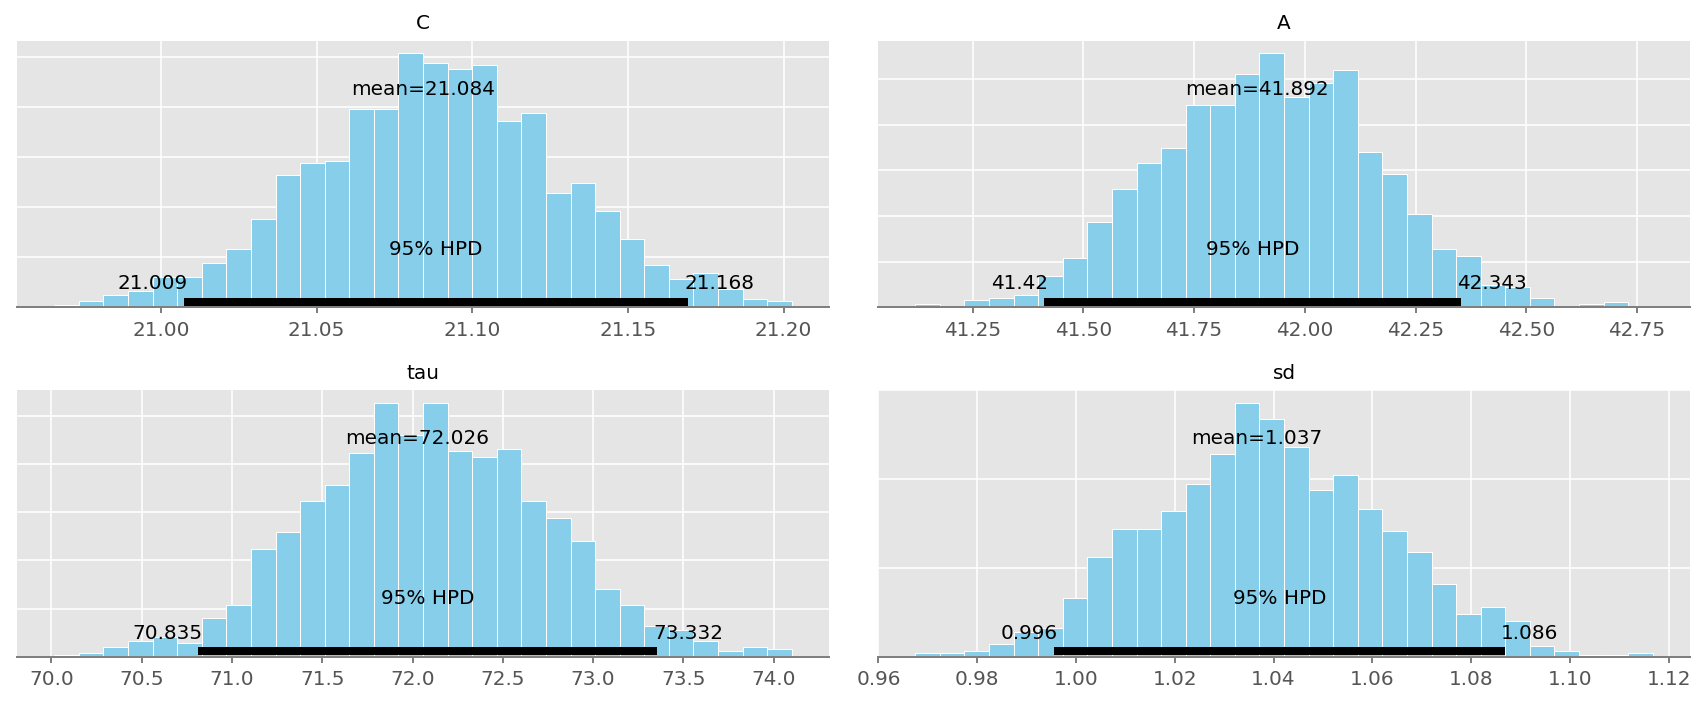

In [82]:
pm.plot_posterior(samples[500:])  #, varnames=['tau'])

## 4. Mosquito Repellant Experiment

In [84]:
mosq_df = pd.read_csv('mosquito_patch.csv')

In [93]:
treatments = ['odo', 'delt', 'cyf', 'do', 'co']
idx = { name : i+1 for i, name in enumerate(treatments) }
odo = mosq_df.loc[mosq_df['trt.mosq'] == idx['odo'] ]
delt = mosq_df.loc[mosq_df['trt.mosq'] == idx['delt'] ]
cyf = mosq_df.loc[mosq_df['trt.mosq'] == idx['cyf'] ]
delt_odo = mosq_df.loc[mosq_df['trt.mosq'] == idx['do'] ]
cyf_odo = mosq_df.loc[mosq_df['trt.mosq'] == idx['co'] ]

Text(0, 0.5, 'Man-Mosquito Contact')

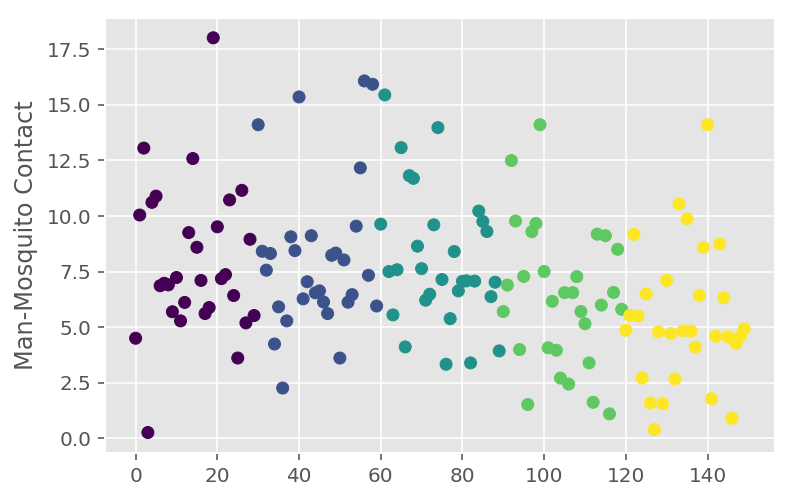

In [186]:
plt.scatter(range(len(mosq_df)), mosq_df['y.mosq'], c=mosq_df['trt.mosq'])
plt.ylabel('Man-Mosquito Contact')

(<matplotlib.axes._subplots.AxesSubplot at 0x11df47320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11df47320>)

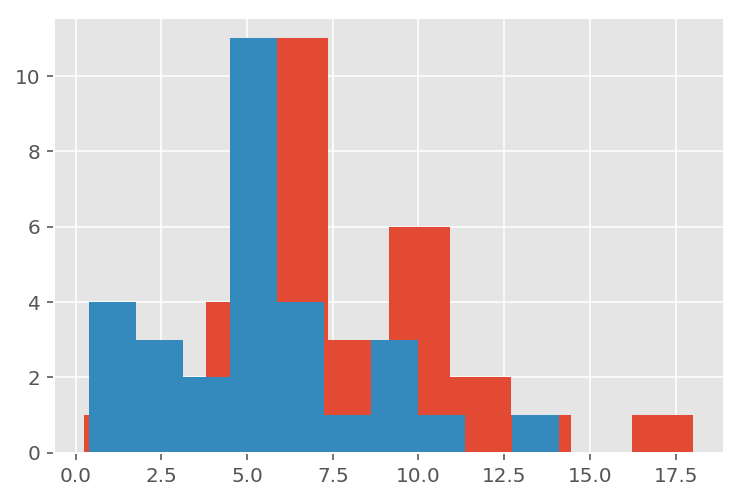

In [100]:
odo['y.mosq'].hist(), cyf_odo['y.mosq'].hist()

In [110]:
with pm.Model() as mosq_model:
    mu_odo = pm.Normal('mu_odo', mu=6, sd=100**2)
    mu_delt = pm.Normal('mu_delt', mu=6, sd=100**2)
    mu_cyf = pm.Normal('mu_cyf', mu=6, sd=100**2)
    mu_odo_delt = pm.Normal('mu_odo_delt', mu=6, sd=100**2)
    
    sigma_odo = pm.HalfCauchy('sigma_odo', beta=100)
    sigma_delt = pm.HalfCauchy('sigma_delt', beta=100)
    sigma_cyf = pm.HalfCauchy('sigma_cyf', beta=100)
    sigma_odo_delt = pm.HalfCauchy('sigma_odo_delt', beta=100)
    
    # nuisance parameter
    nu = pm.Exponential('nu', lam=1/29) + 1  # so we dont get nu=0 by rounding error
    
    # Likelihoods
    odo_like = pm.StudentT('odo', nu=nu, mu=mu_odo, sd=sigma_odo,
                       observed=odo['y.mosq'])
    delt_like = pm.StudentT('delt', nu=nu, mu=mu_delt, sd=sigma_delt,
                       observed=delt['y.mosq'])
    cyf_like = pm.StudentT('cyf', nu=nu, mu=mu_cyf, sd=sigma_cyf,
                       observed=cyf['y.mosq'])
    odo_delt_like = pm.StudentT('odo_delt', nu=nu, mu=mu_odo_delt, sd=sigma_odo_delt,
                       observed=delt_odo['y.mosq'])
    
    # calculate effect size and uncertainty
    diff_means = pm.Deterministic('diff_means', mu_odo_delt - mu_delt)
    pooled_sd = pm.Deterministic('pooled_sd',
                                 np.sqrt(np.power(sigma_odo_delt, 2) + 
                                         np.power(sigma_delt, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', diff_means / pooled_sd)

In [111]:
with mosq_model:
    samples = pm.sample(5000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, sigma_odo_delt, sigma_cyf, sigma_delt, sigma_odo, mu_odo_delt, mu_cyf, mu_delt, mu_odo]
100%|██████████| 5500/5500 [00:16<00:00, 327.68it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x126bd60b8>,
      dtype=object)

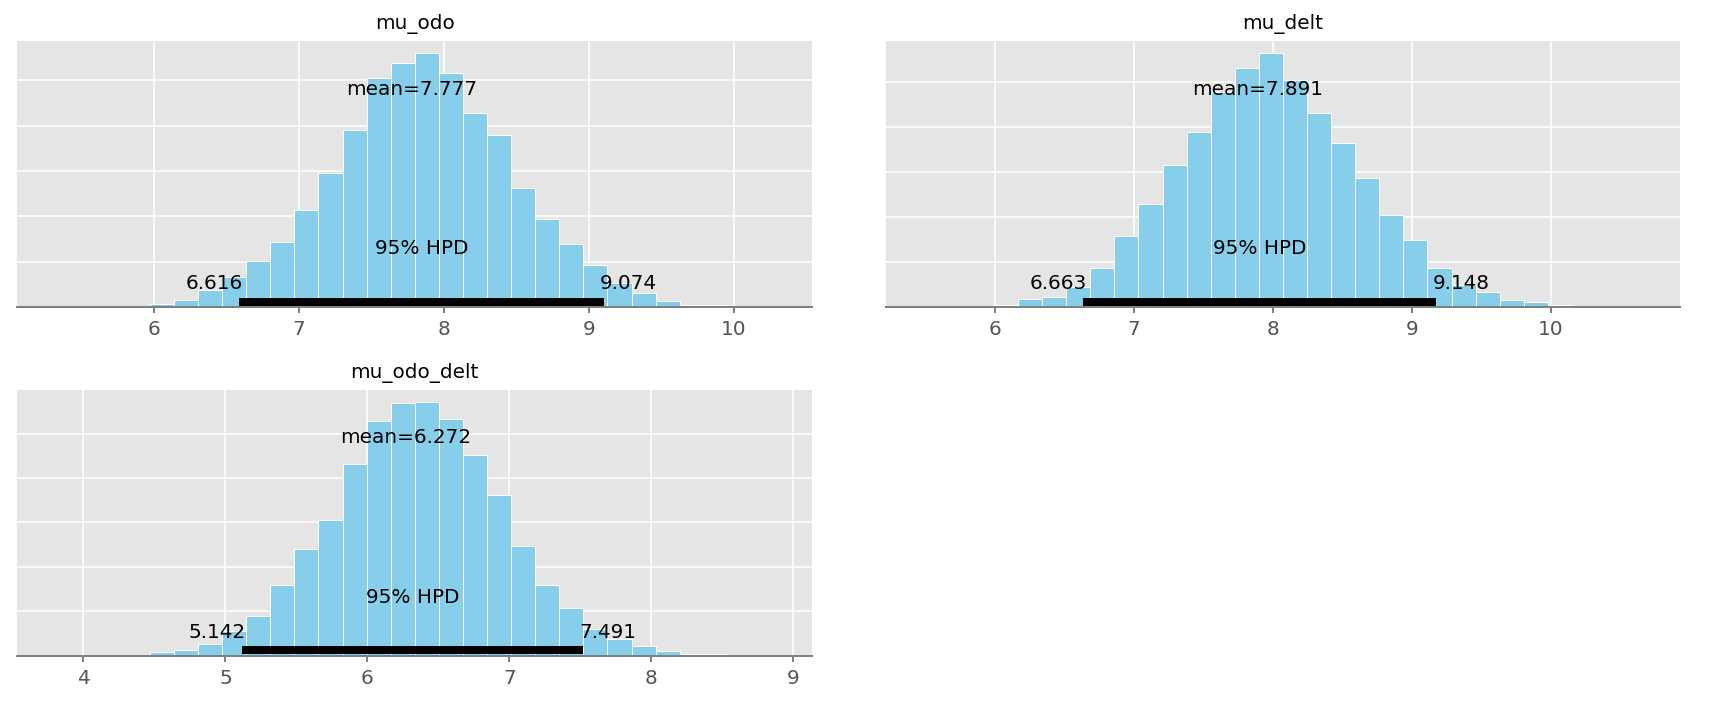

In [112]:
pm.plot_posterior(samples, varnames=['mu_odo', 'mu_delt', 'mu_odo_delt'])

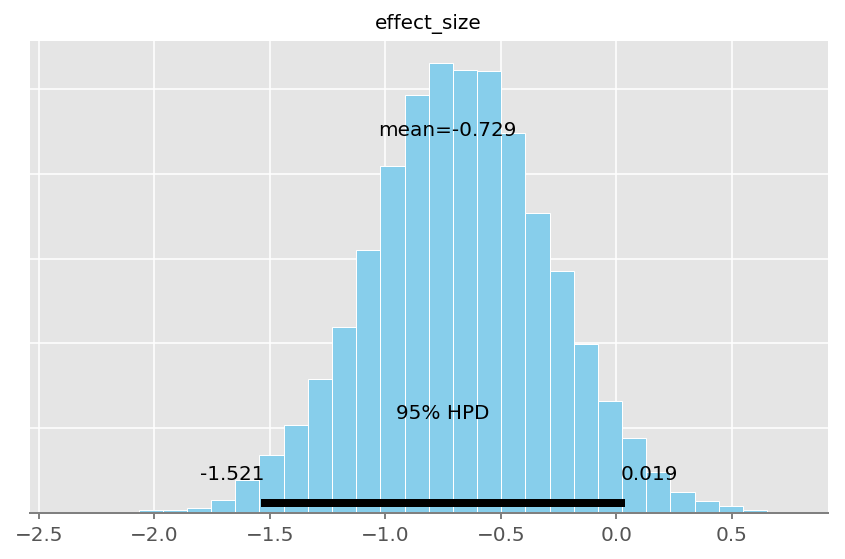

In [113]:
pm.plot_posterior(samples, varnames=['effect_size'])

In [187]:
def pool_sd(sigma1, sigma2):
     return np.sqrt(np.power(sigma1, 2) + np.power(sigma2, 2)) / 2

In [192]:
with pm.Model() as mosq_hier_model:
    mu_odo = pm.Normal('mu_odo', mu=6, sd=100**2)
    mu_delt = pm.Normal('mu_delt', mu=6, sd=100**2)
    mu_hyper = mu_odo + mu_delt / 2
    
    sigma_odo = pm.HalfCauchy('sigma_odo', beta=100)
    sigma_delt = pm.HalfCauchy('sigma_delt', beta=100)
    
    mu_odo_delt = pm.Normal('mu_odo_delt', mu=mu_hyper, sd=100**2)
    sigma_odo_delt = pm.HalfCauchy('sigma_odo_delt', beta=100)
    
    # nuisance parameter
    nu = pm.Exponential('nu', lam=1/29) + 1  # so we dont get nu=0 by rounding error
    
    # Likelihoods
    odo_like = pm.StudentT('odo', nu=nu, mu=mu_odo, sd=sigma_odo,
                       observed=odo['y.mosq'])
    delt_like = pm.StudentT('delt', nu=nu, mu=mu_delt, sd=sigma_delt,
                       observed=delt['y.mosq'])
    odo_delt_like = pm.StudentT('odo_delt', nu=nu, mu=mu_odo_delt, sd=sigma_odo_delt,
                       observed=delt_odo['y.mosq'])
    
    # calculate effect size and uncertainty
    diff_means = pm.Deterministic('diff_means', mu_odo_delt - mu_delt)
    pooled_sd = pm.Deterministic('pooled_sd',
                                 np.sqrt(np.power(sigma_odo_delt, 2) + 
                                         np.power(sigma_delt, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', diff_means / pooled_sd)
    
    samples = pm.sample(5000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, sigma_odo_delt, mu_odo_delt, sigma_delt, sigma_odo, mu_delt, mu_odo]
100%|██████████| 5500/5500 [00:15<00:00, 346.71it/s]


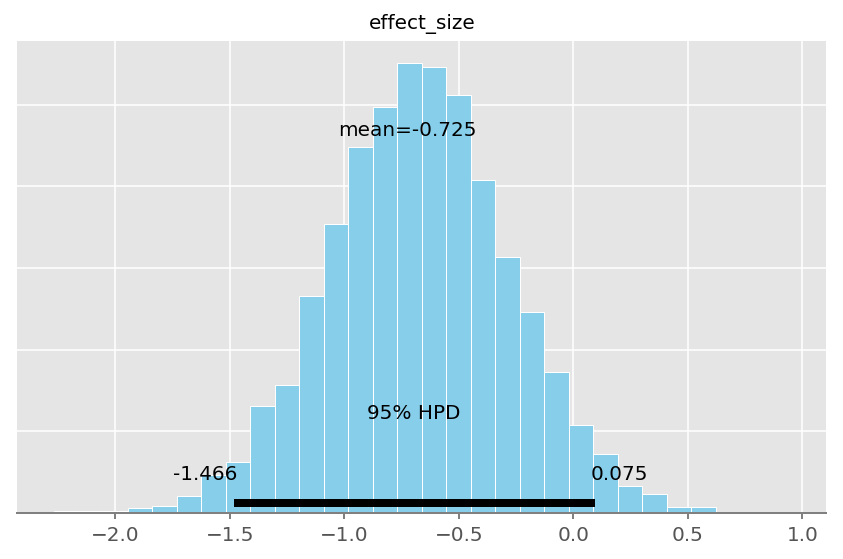

In [193]:
pm.plot_posterior(samples, varnames=['effect_size'])

## 5. BioFilm Problem

> Summary of experiment

> Treatment group A was higher than control (effect size 95% HP : [ **lower**, **upper** ])
--

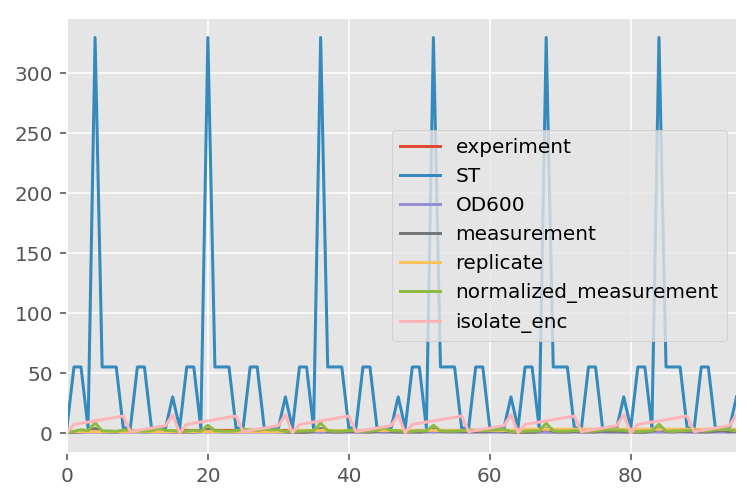

In [117]:
from data import load_biofilm

bio_df = load_biofilm()
bio_df.plot()

In [205]:
bio_df.sample(8)

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement,isolate_enc
70,1,7,55.0,0.551,0.720,3.0,1.306715,12
65,1,2,55.0,0.346,0.450,3.0,1.300578,7
30,2,15,4.0,0.427,1.091,1.0,2.555035,6
64,1,1,4.0,0.461,0.369,3.0,0.800434,0
34,1,3,55.0,0.356,0.585,2.0,1.643258,8
59,2,12,55.0,0.527,0.925,2.0,1.755218,3
25,2,10,4.0,0.473,1.304,1.0,2.756871,1
75,1,12,55.0,0.516,0.829,3.0,1.606589,3


In [125]:
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_one', lam=1/30) + 1
    
    fold = pm.Flat('fold', shape=len(set(bio_df['isolate_enc'])))
    
    var = pm.HalfCauchy('var', beta=1, shape=len(set(bio_df['isolate_enc'])))
    
    mu = fold[bio_df['isolate_enc'].values]
    sd = var[bio_df['isolate_enc'].values]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, 
                       observed=bio_df['normalized_measurement'])
    
    # Compute differences
    diffs = pm.Deterministic('differences', fold[1:] - fold[0])

In [126]:
with best:
    trace = pm.sample(draws=2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [var, fold, nu_minus_one]
100%|██████████| 2500/2500 [00:07<00:00, 350.71it/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12969b828>,
      dtype=object)

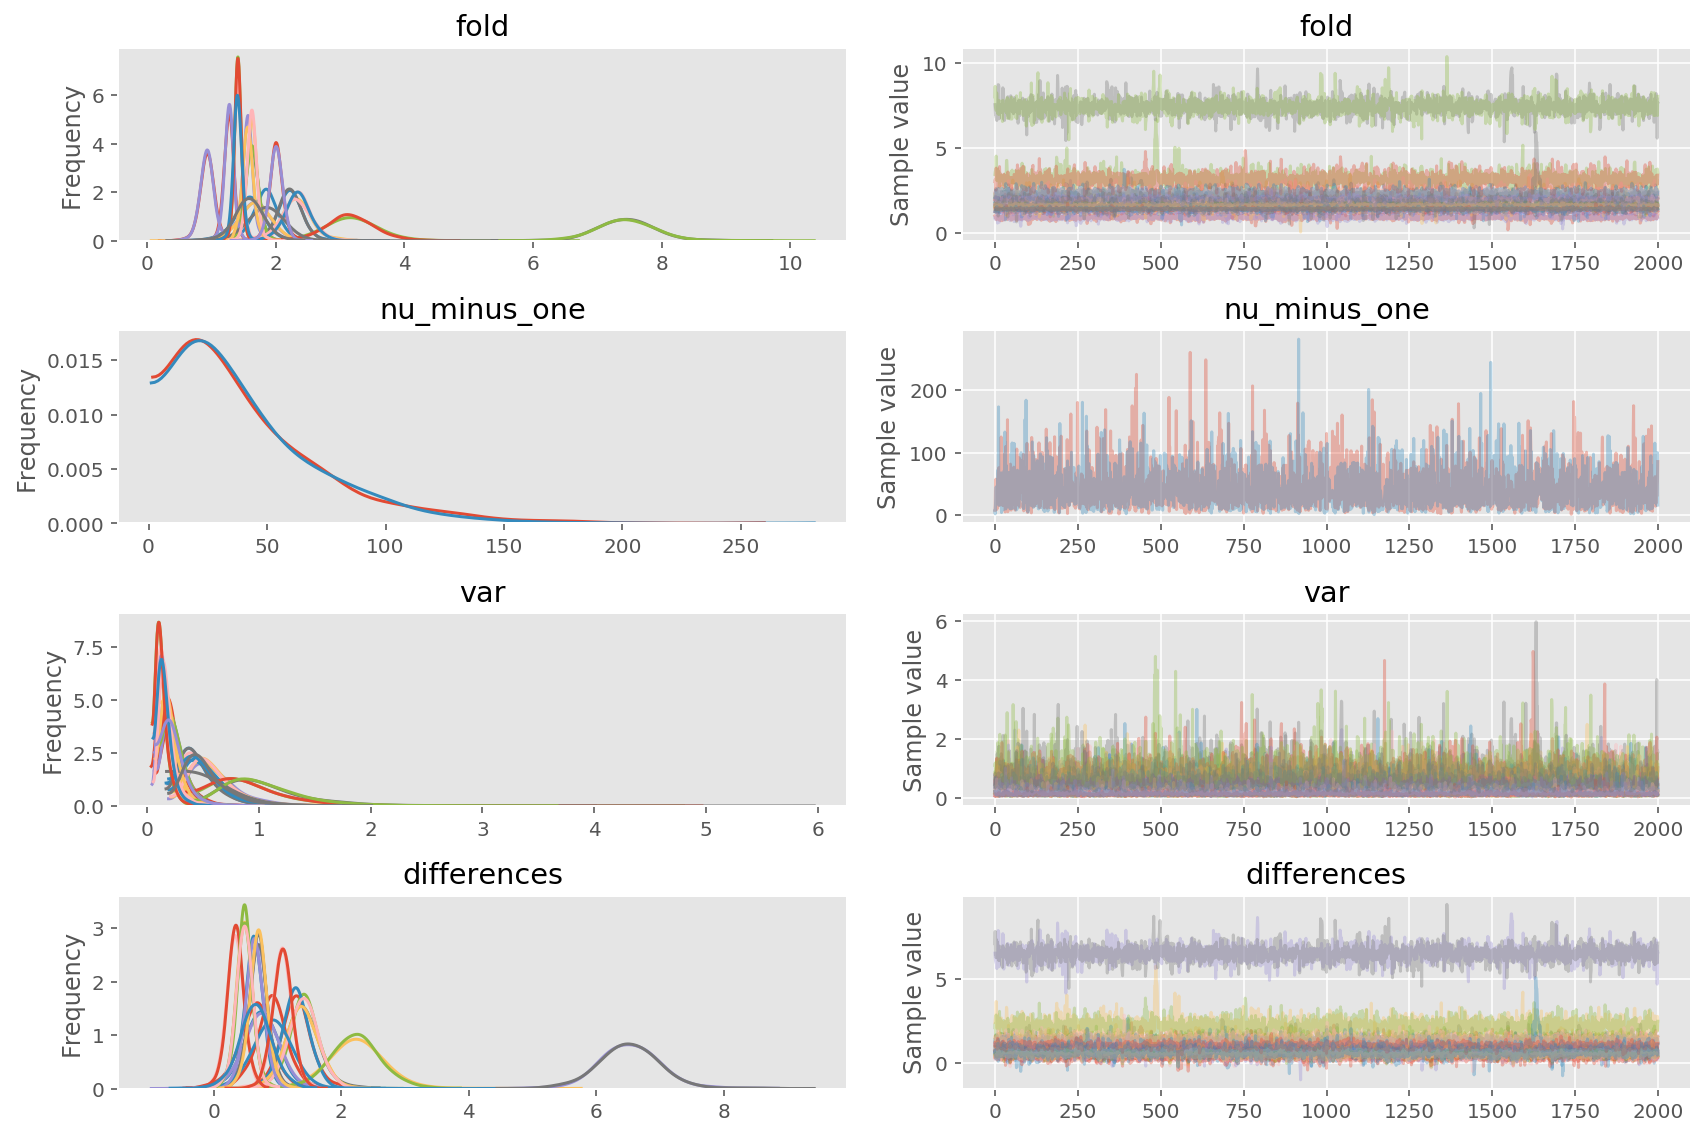

In [127]:
pm.traceplot(trace)

GridSpec(1, 1)

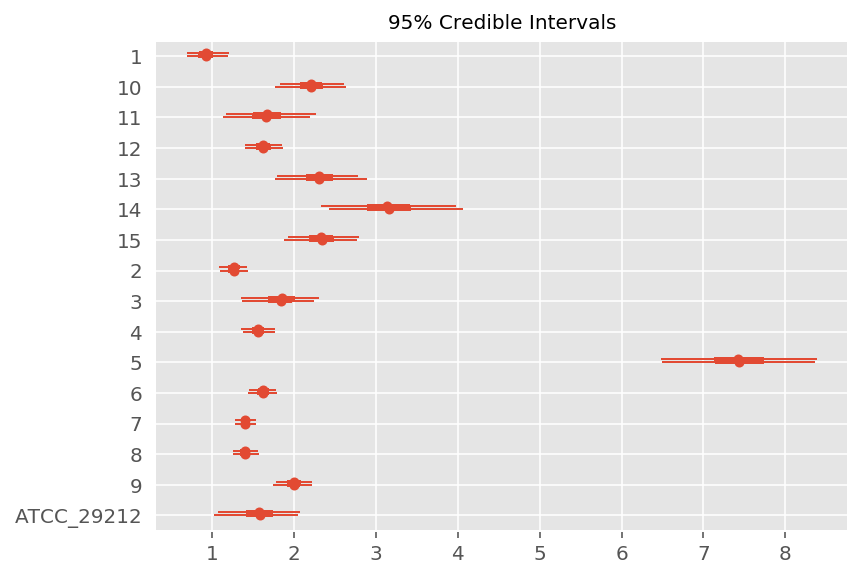

In [131]:
mapping = dict(zip(bio_df['isolate_enc'], bio_df['isolate']))
ylabels = [mapping[i] for i in sorted(mapping.keys())]
pm.forestplot(trace, varnames=['fold'], ylabels=ylabels, rhat=False)

GridSpec(1, 1)

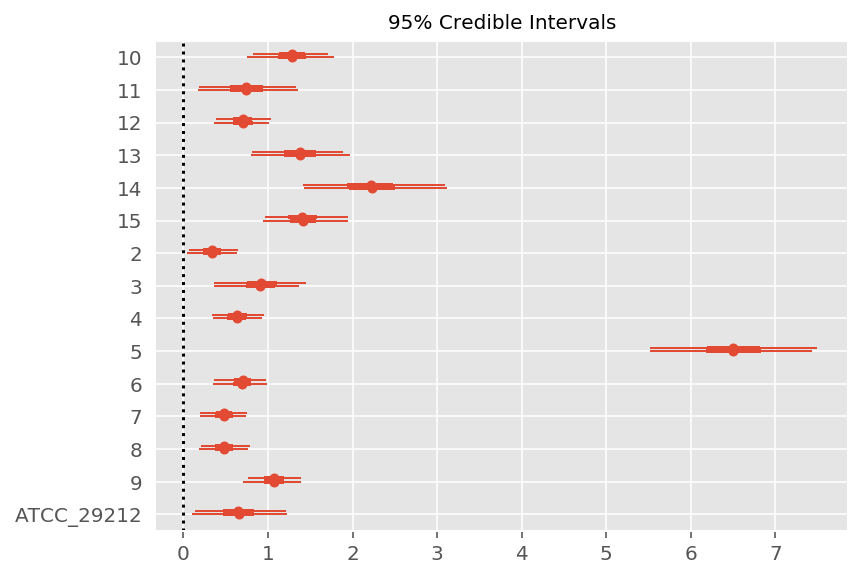

In [132]:
pm.forestplot(trace, varnames=['differences'], ylabels=ylabels[1:], rhat=False)

### Model Check

In [134]:
ppc_samples = pm.sample_ppc(trace, model=best)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 4000/4000 [00:04<00:00, 999.21it/s] 


In [147]:
indices = dict()
for enc, iso in mapping.items():
    idxs = list(bio_df[bio_df['isolate_enc'] == enc].index)
    indices[iso] = idxs

In [144]:
from matplotlib.gridspec import GridSpec
from utils import ecdf

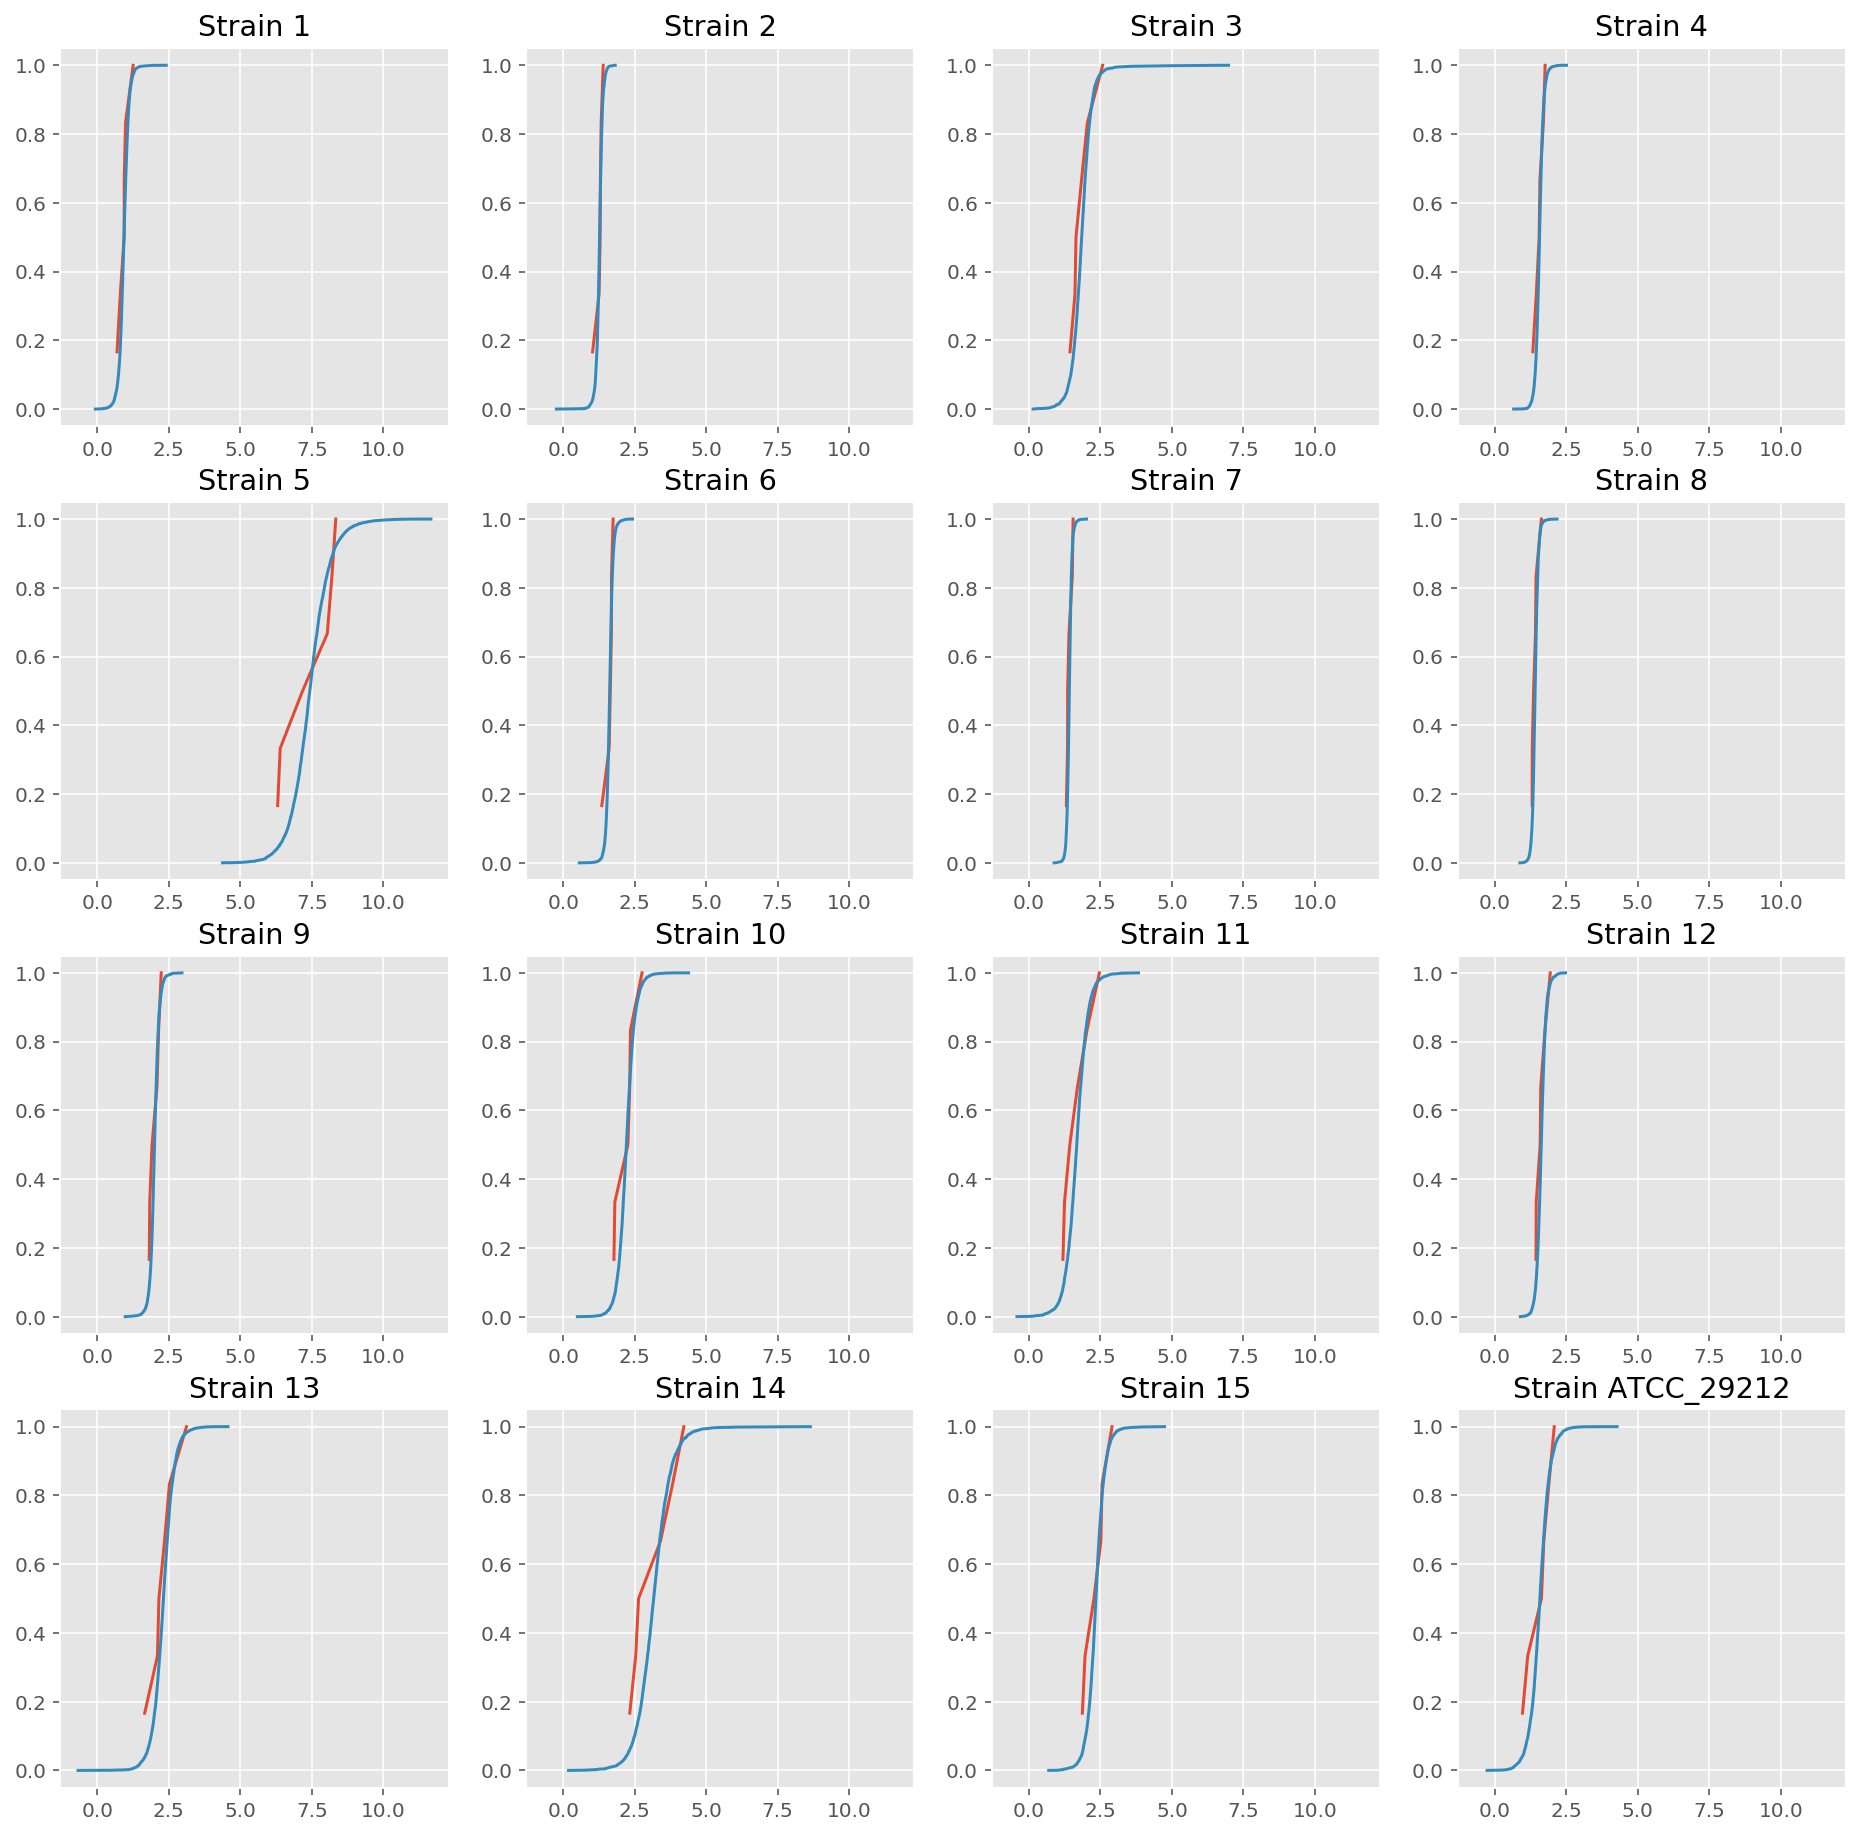

In [148]:
# Make PPC plot for one of the groups.
fig = plt.figure(figsize=(16, 16))
gs = GridSpec(nrows=4, ncols=4)
axes = dict()


for i, (strain, idxs) in enumerate(indices.items()):
    if i > 0:
        ax = fig.add_subplot(gs[i], sharex=axes[0])
    else:
        ax = fig.add_subplot(gs[i])
    x, y = ecdf(bio_df.iloc[idxs]['normalized_measurement'])
    ax.plot(x, y, label='data')
    x, y = ecdf(ppc_samples['like'][:, idxs].mean(axis=1))
    ax.plot(x, y, label='ppc')
    ax.set_title(f'Strain {strain}')
    axes[i] = ax

## [Optional] Dose-Response (Activation)

In [149]:
from data import load_dose_response

act_df = load_dose_response()

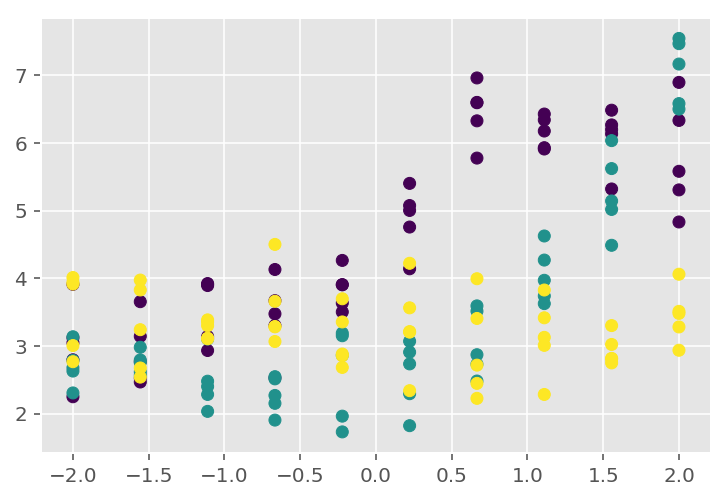

In [151]:
plt.scatter(act_df['concentration'], act_df['response'], c=act_df['molecule'])

In [153]:
from data import dose_response

In [154]:
with pm.Model() as model:
    lower = pm.Normal('lower', mu=0, sd=10, shape=(3,))
    upper = pm.Normal('upper', mu=10, sd=10, shape=(3,))
    c50 = pm.Normal('c50', mu=0, sd=10, shape=(3,))
    slope = pm.HalfNormal('slope', sd=10, shape=(3,))
    
    mu = dose_response(act_df['concentration'], 
                       lower[act_df['molecule'].values], 
                       upper[act_df['molecule'].values], 
                       slope[act_df['molecule'].values], 
                       c50[act_df['molecule'].values])
    
    sd = pm.HalfNormal('sd', sd=10, shape=(3,))
    y = pm.Normal('like', mu=mu, sd=sd[act_df['molecule'].values], observed=act_df['response'])

In [155]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, slope, c50, upper, lower]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:38<00:00, 128.77draws/s]
There were 469 divergences after tuning. Increase `target_accept` or reparameterize.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126b4ef60>,
      dtype=object)

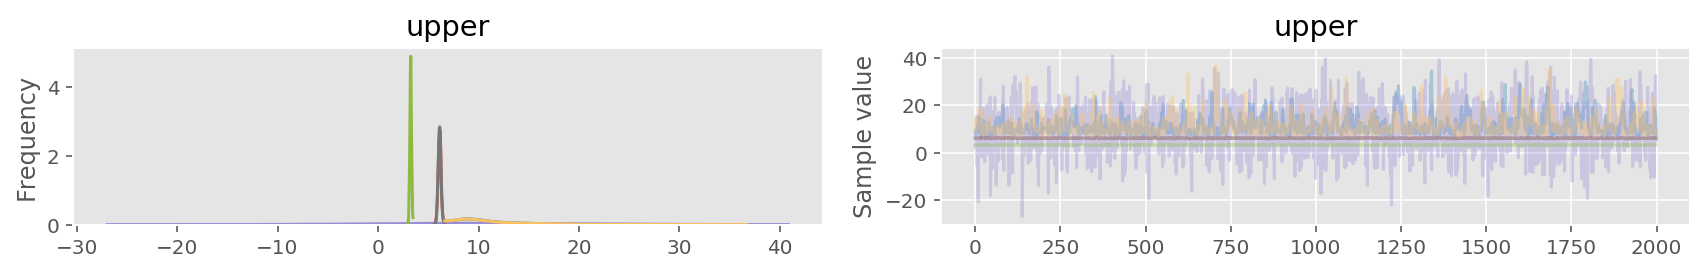

In [156]:
pm.traceplot(trace, varnames=['upper'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x126b92860>,
      dtype=object)

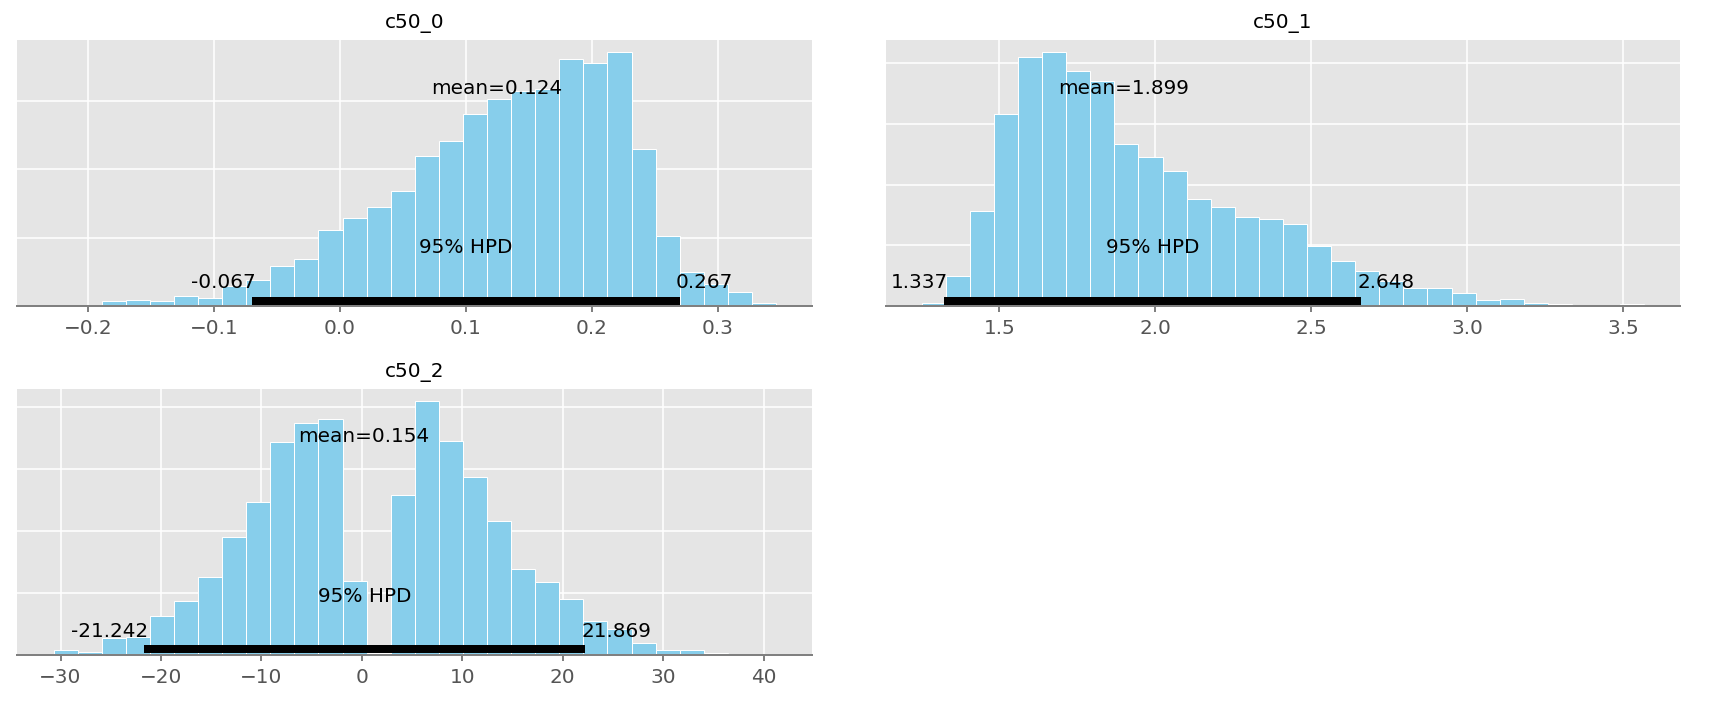

In [157]:
pm.plot_posterior(trace, varnames=['c50'])